<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Kalman Filtering for Indoor Localization
</p>

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pykalman import KalmanFilter
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [3]:
# Load data and convert time column
df = pd.read_csv('../all_data_files/cleaned_dataset_per_device.csv')
df['time'] = pd.to_datetime(df['time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728162 entries, 0 to 728161
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   time         728162 non-null  datetime64[ns, UTC]
 1   device_id    728162 non-null  object             
 2   co2          728162 non-null  float64            
 3   humidity     728162 non-null  float64            
 4   pm25         728162 non-null  float64            
 5   pressure     728162 non-null  float64            
 6   temperature  728162 non-null  float64            
 7   rssi         728162 non-null  float64            
 8   snr          728162 non-null  float64            
 9   SF           728162 non-null  int64              
 10  frequency    728162 non-null  float64            
 11  f_count      728162 non-null  float64            
 12  p_count      728162 non-null  float64            
 13  toa          728162 non-null  float64            
 14  dist

In [4]:
# 80-20 stratified train-test split ensuring all 6 devices are included in both sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['device_id'], random_state=42)
# Sort by time for clarity in plotting
train_df = train_df.sort_values('time')
test_df = test_df.sort_values('time')

In [5]:
# Define Kalman filter function and apply it separately on train and test sets per device
def kalman_filter_rssi(rssi_measurements):
    kf = KalmanFilter(
        initial_state_mean=rssi_measurements[0],
        observation_covariance=0.5,
        transition_covariance=0.01
    )
    # kf.smooth returns (smoothed_state_means, smoothed_state_covariances)
    return kf.smooth(rssi_measurements)[0].flatten()

# Apply Kalman filter on training data per device
train_df['filtered_rssi'] = train_df.groupby('device_id')['rssi'].transform(
    lambda x: kalman_filter_rssi(x.values)
)
# Compute exp_pl_filtered for training data using: 
                    # exp_pl_filtered = 14 - 1 + 1.4 + 3 - filtered_rssi
                    # From: tx_p=14, tx_cl=1, tx_ag=1.4, rx_ag=3, tx_cl=0
train_df['exp_pl_filtered'] = 14 - 1 + 1.4 + 3 - train_df['filtered_rssi']

# Apply Kalman filter on test data per device (separately)
test_df['filtered_rssi'] = test_df.groupby('device_id')['rssi'].transform(
    lambda x: kalman_filter_rssi(x.values)
)

# Compute exp_pl_filtered for test data
test_df['exp_pl_filtered'] = 14 - 1 + 1.4 + 3 - test_df['filtered_rssi']

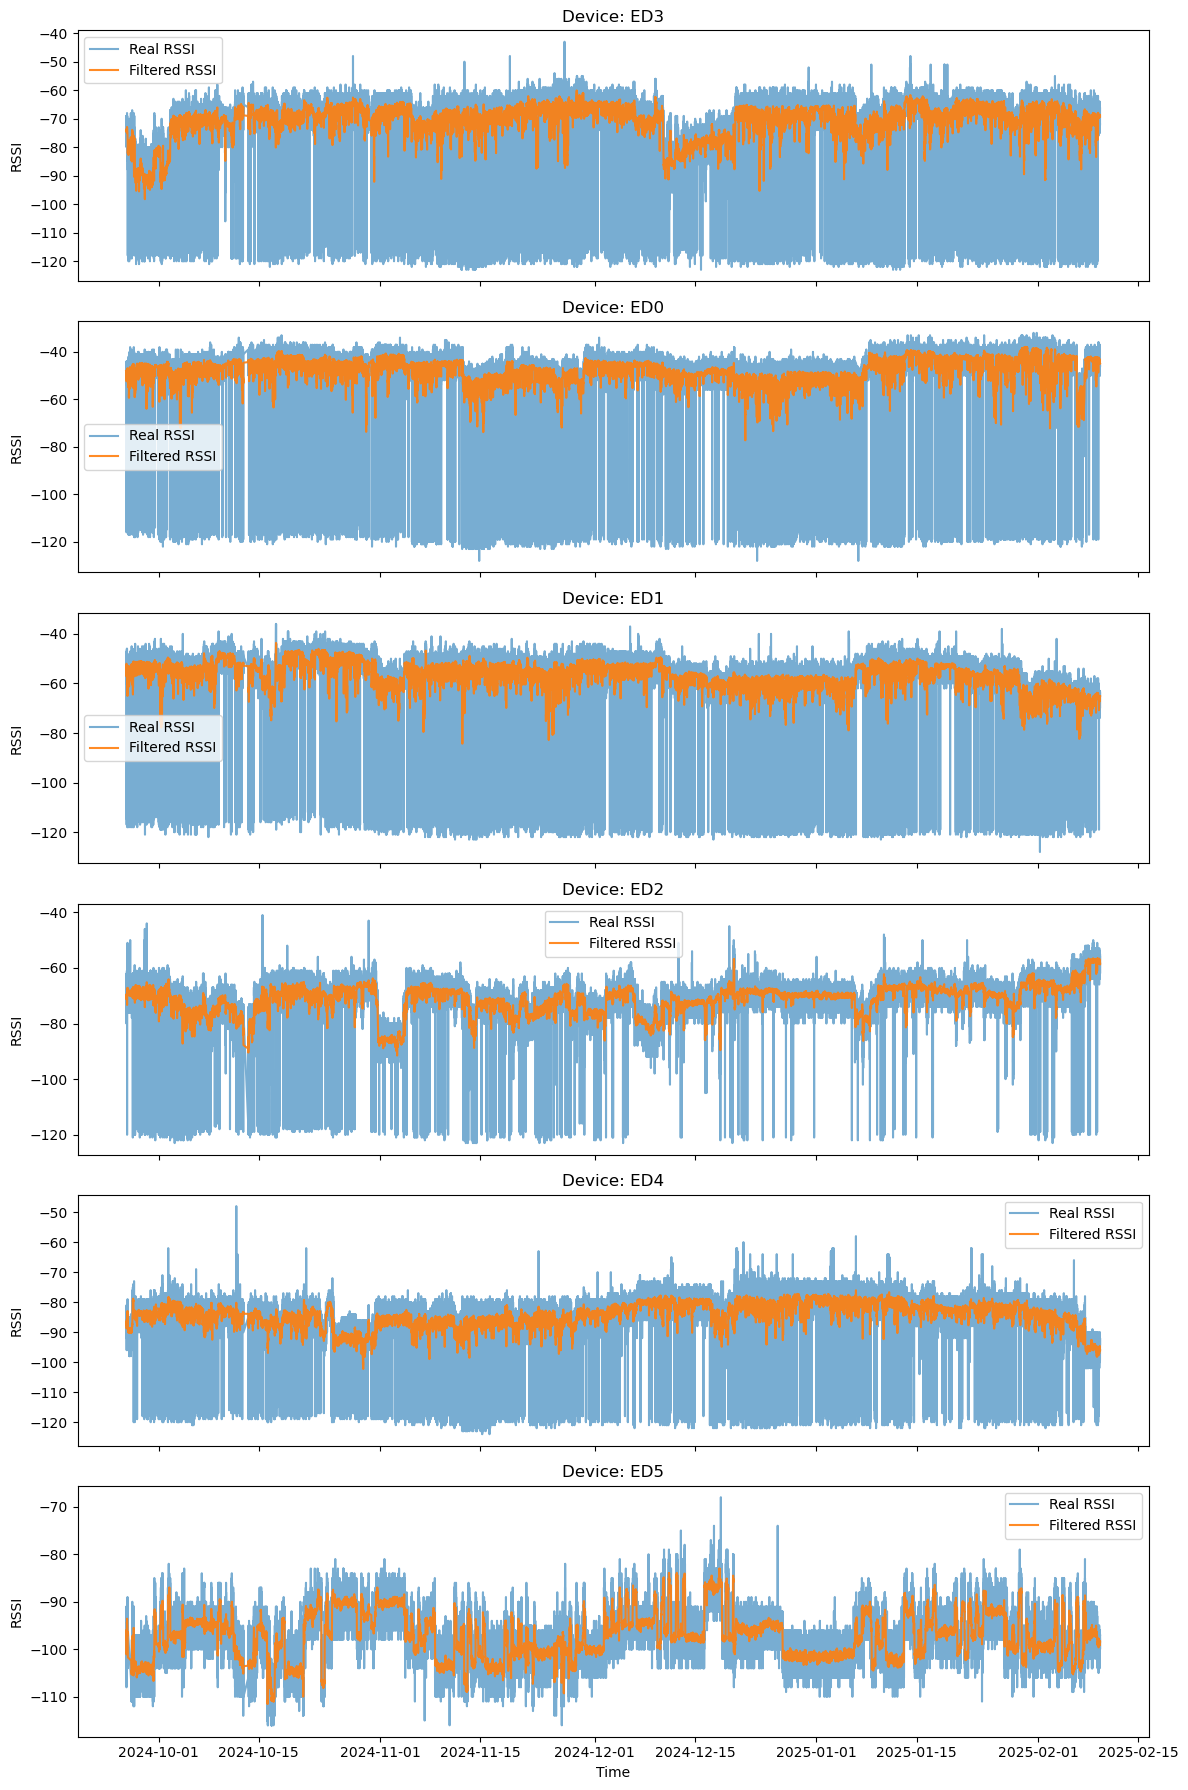

In [6]:
# Plot train data (Real vs. Filtered RSSI) for each device
device_ids = train_df['device_id'].unique()
num_devices = len(device_ids)
fig, axes = plt.subplots(nrows=num_devices, ncols=1, figsize=(12, 3*num_devices), sharex=True)
if num_devices == 1:
    axes = [axes]

for ax, device in zip(axes, device_ids):
    device_data = train_df[train_df['device_id'] == device].sort_values('time')
    ax.plot(device_data['time'], device_data['rssi'], label='Real RSSI', alpha=0.6)
    ax.plot(device_data['time'], device_data['filtered_rssi'], label='Filtered RSSI', alpha=0.9)
    ax.set_title(f'Device: {device}')
    ax.set_ylabel('RSSI')
    ax.legend()

plt.xlabel('Time')
plt.tight_layout()
plt.show()

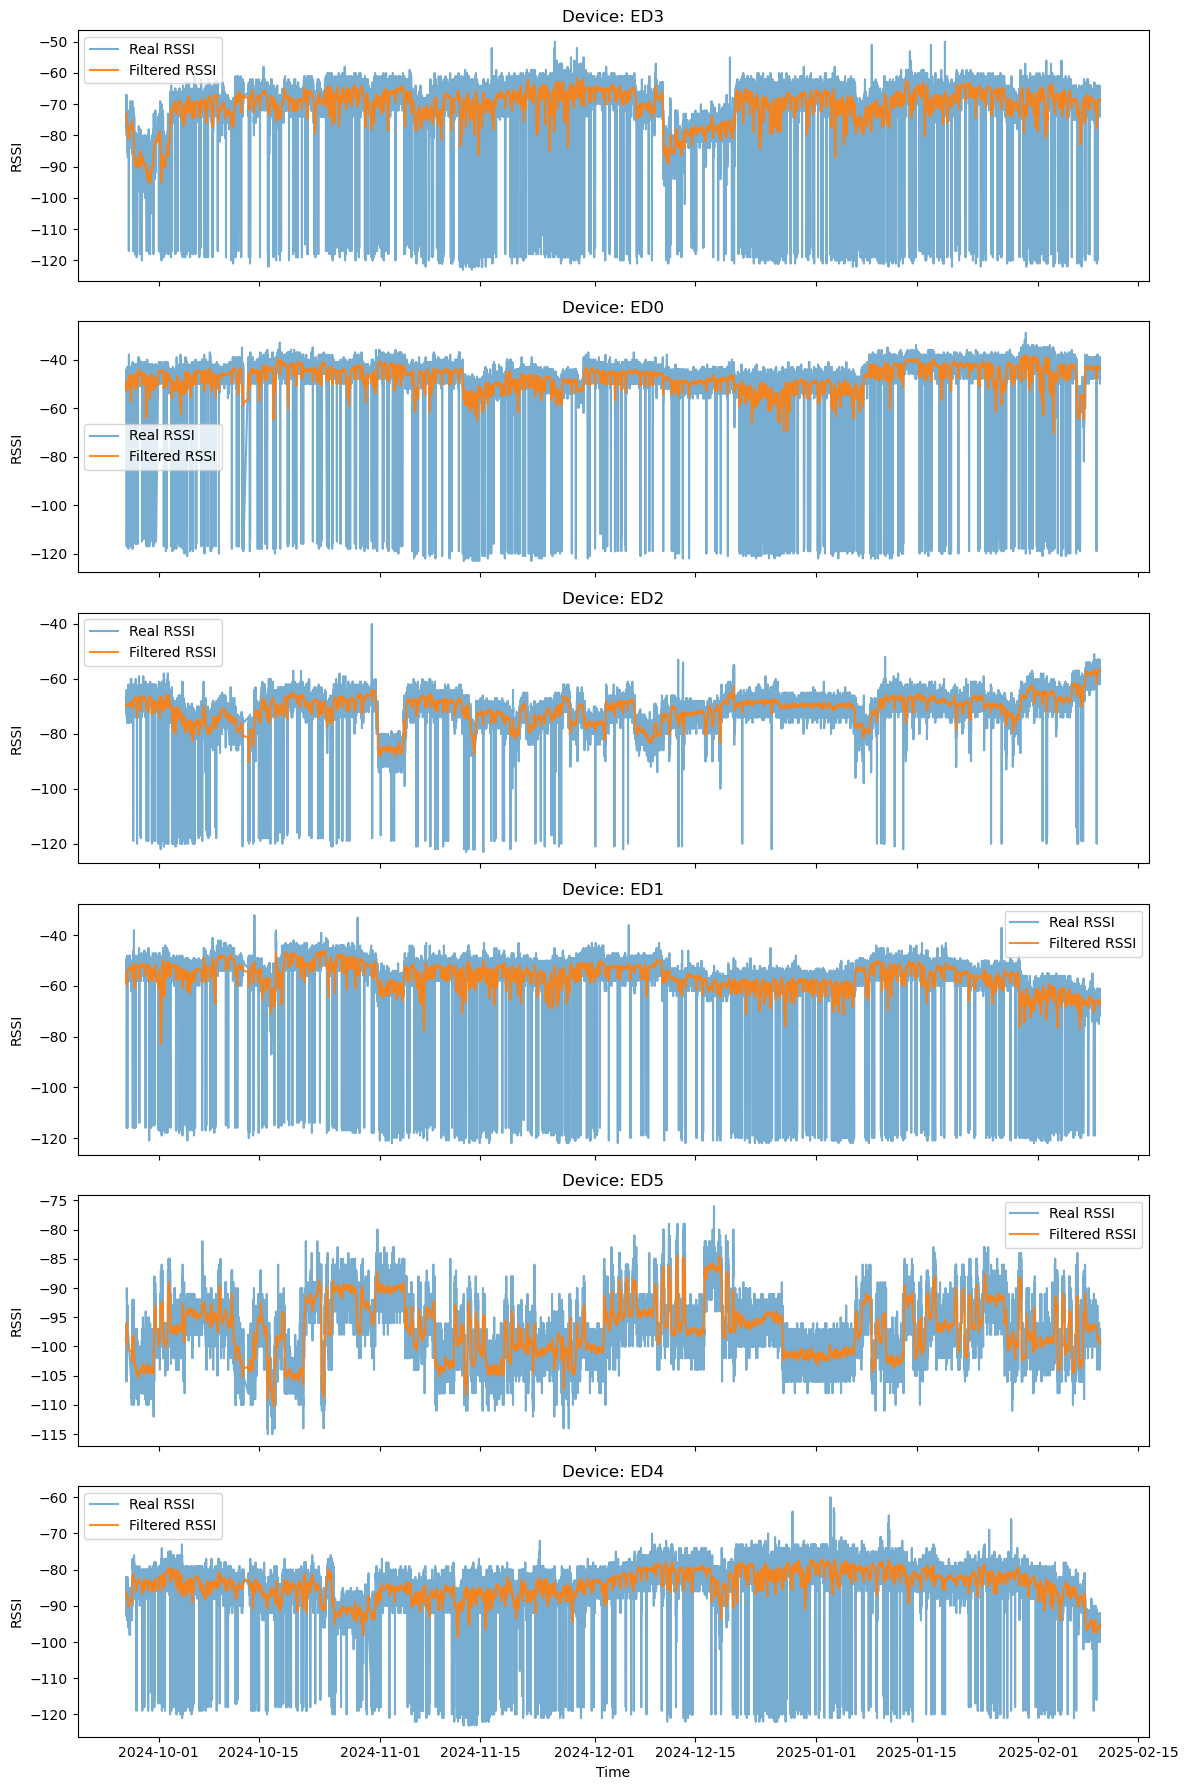

In [7]:
# Plot test data (Real vs. Filtered RSSI) for each device
device_ids_test = test_df['device_id'].unique()
num_devices_test = len(device_ids_test)
fig, axes = plt.subplots(nrows=num_devices_test, ncols=1, figsize=(12, 3*num_devices_test), sharex=True)
if num_devices_test == 1:
    axes = [axes]

for ax, device in zip(axes, device_ids_test):
    device_data = test_df[test_df['device_id'] == device].sort_values('time')
    ax.plot(device_data['time'], device_data['rssi'], label='Real RSSI', alpha=0.6)
    ax.plot(device_data['time'], device_data['filtered_rssi'], label='Filtered RSSI', alpha=0.9)
    ax.set_title(f'Device: {device}')
    ax.set_ylabel('RSSI')
    ax.legend()

plt.xlabel('Time')
plt.tight_layout()
plt.show()